# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, concat, col, desc, year, month, asc, count, avg, countDistinct
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as func

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler,Normalizer,StandardScaler,IDF,StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from matplotlib import pyplot as plt
from datetime import date


In [2]:
# create a Spark session
spark = SparkSession.builder.appName("sparkify").getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
data = spark.read.json("mini_sparkify_event_data.json")
data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

(0, 550)

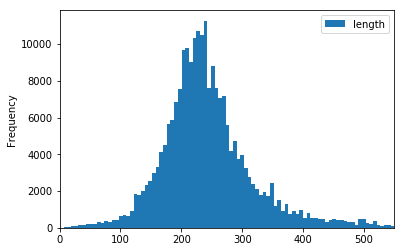

In [4]:
# length visual
data_pd = data.select("length").toPandas()
data_pd.plot(kind = "hist", bins = 500)
plt.xlim(0, 550)

In [5]:
data = data.dropna(how = "any",subset=["userId","sessionId"])

In [6]:
data = data.filter(data["userId"] != "")

In [7]:
data.count()

278154

# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [8]:
churn_func = udf(lambda x: 1 if x == "Cancellation Confirmation" or x == "Downgrade" else 0, IntegerType())

In [9]:
data = data.withColumn("Churn", churn_func(data.page))

In [10]:
get_datetime_func = udf(lambda x : date.fromtimestamp(x/1000).isoformat())
data = data.withColumn("dt", get_datetime_func(data.ts))

In [11]:
data.groupBy(["userId","dt","Churn","page"]) \
    .agg({"page":"count"}) \
    .withColumnRenamed("count(page)","cp") \
    .orderBy([desc("userId"),desc("dt")]).show()

+------+----------+-----+---------------+---+
|userId|        dt|Churn|           page| cp|
+------+----------+-----+---------------+---+
|    99|2018-11-27|    0|     Add Friend|  2|
|    99|2018-11-27|    0|           Home|  3|
|    99|2018-11-27|    0|       NextSong|107|
|    99|2018-11-27|    0|    Thumbs Down|  1|
|    99|2018-11-27|    0|         Logout|  2|
|    99|2018-11-27|    1|      Downgrade|  1|
|    99|2018-11-27|    0|Add to Playlist|  3|
|    99|2018-11-27|    0|      Thumbs Up|  7|
|    99|2018-11-26|    0|      Thumbs Up|  2|
|    99|2018-11-26|    0|       NextSong|  5|
|    99|2018-11-24|    1|      Downgrade|  1|
|    99|2018-11-24|    0|    Thumbs Down|  1|
|    99|2018-11-24|    0|      Thumbs Up|  6|
|    99|2018-11-24|    0|Add to Playlist|  4|
|    99|2018-11-24|    0|       NextSong|118|
|    99|2018-11-24|    0|         Logout|  2|
|    99|2018-11-24|    0|           Home|  4|
|    99|2018-11-24|    0|           Help|  1|
|    99|2018-11-24|    0|     Add 

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

### Numberic Features

In [12]:
# count songs
df_songs = data.groupBy("userId").agg(countDistinct("song").alias("countSong")).orderBy("userId")

In [13]:
# calc avg listen time
df_avg_length = data.groupBy("userId").agg(avg("length").alias("avgLength")).orderBy("userId")

In [14]:
# count all artist for each user
df_singers = data.dropDuplicates(["userId", "artist"]).groupBy("userId").agg(count("artist").alias("countArtist")).orderBy("userId")

### Category Features

In [15]:
# select category features
df_catgory = data.select(["userId", "gender", "level", "location", "method"])

In [16]:
df_catgory = df_catgory.dropDuplicates(["userId"]).orderBy(desc("userId"))

In [17]:
#  user may have 2 Churn values, we keep value 1 only
df_calced = data.select("Churn","userId").orderBy(desc("Churn")).dropDuplicates(["userId"])

In [18]:
# join all features
for feature in [df_songs, df_avg_length, df_singers, df_catgory]:
    df_calced = df_calced.join(feature, ["userId"], how="left")

In [19]:
df_calced = df_calced.na.drop()

In [20]:
# convert category features to numberic
for index in ["gender", "level", "location", "method"]:
    indexer = StringIndexer(inputCol=index, outputCol=f"{index}Indexer")
    _fit = indexer.fit(df_calced)
    df_calced = _fit.transform(df_calced)

In [21]:
assembler = VectorAssembler(inputCols=["countSong", "avgLength", "countArtist", "genderIndexer", "levelIndexer", "locationIndexer", "methodIndexer"], outputCol="featuresVec")
df_calced = assembler.transform(df_calced)

In [22]:
stander = StandardScaler(inputCol="featuresVec", outputCol="features")
stander_fit = stander.fit(df_calced)
df_calced = stander_fit.transform(df_calced)

In [23]:
drop_columns = ["userId", "gender", "level", "location", "method"]
for column in drop_columns:
    df_calced = df_calced.drop(column)

In [24]:
df_calced.take(1)

[Row(Churn=0, countSong=269, avgLength=243.421444909091, countArtist=252, genderIndexer=1.0, levelIndexer=0.0, locationIndexer=26.0, methodIndexer=1.0, featuresVec=DenseVector([269.0, 243.4214, 252.0, 1.0, 0.0, 26.0, 1.0]), features=DenseVector([0.3001, 40.9675, 0.4173, 2.0013, 0.0, 0.7691, 1.996]))]

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

In [25]:
train, test, val = df_calced.randomSplit([0.7, 0.15, 0.15], seed = 58)

### LinearRegression

In [26]:
lr = LinearRegression(labelCol="Churn", featuresCol="features", fitIntercept=False, regParam=0.0, solver="normal")
model = lr.fit(train) 

In [27]:
train_pre = model.transform(train)
test_pre = model.transform(test)

In [28]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction",labelCol="Churn")

In [29]:
print("LinearRegression Accuracy for train dataset:", evaluator.evaluate(train_pre))
print("LinearRegression Accuracy for test dataset:", evaluator.evaluate(test_pre))

LinearRegression Accuracy for train dataset: 0.8995205336668749
LinearRegression Accuracy for test dataset: 0.9357142857142857


### LogistRegression

In [30]:
logist_lr = LogisticRegression(labelCol="Churn", featuresCol="features")
logist_model = logist_lr.fit(train)

In [31]:
train_pre_logist = logist_model.transform(train)
test_pre_logist = logist_model.transform(test)

In [32]:
print("LogistRegression Accuracy for train dataset:", evaluator.evaluate(train_pre_logist))
print("LogistRegression Accuracy for test dataset:", evaluator.evaluate(test_pre_logist))

LogistRegression Accuracy for train dataset: 0.8627267041901189
LogistRegression Accuracy for test dataset: 0.8107142857142858


### RandomForest Regression

In [33]:
forest = RandomForestClassifier(labelCol="Churn", featuresCol="features", maxDepth=10)
forest_model = forest.fit(train)

In [34]:
train_pre_forest = forest_model.transform(train)
test_pre_forest = forest_model.transform(test)

In [35]:
print("RandomForest Regression Accuracy for train dataset:", evaluator.evaluate(train_pre_forest))
print("RandomForest Regression Accuracy for test dataset:", evaluator.evaluate(test_pre_forest))

RandomForest Regression Accuracy for train dataset: 1.0
RandomForest Regression Accuracy for test dataset: 0.8285714285714286


In [36]:
# base on final result , use linearregression as the final model
val_pre = model.transform(val)
print("Val dataset accuracy:", evaluator.evaluate(val_pre))

Val dataset accuracy: 0.8701923076923077


# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。